# Implicit Differentiation


A key numerical operation we do in data analysis is optimization, not only to e.g. optimize a neural network but often optimization is part of the "forward computation"


Let's say you have an optimization problem $f_\phi(x)$. For this function $f$ there is a well defined minimizer $\hat{x}$

$$\hat{x}_\phi = \mathrm{argmin}f_\phi(x)$$

That you can find using standard gradient descent.


But what's the derivative

$$\frac{\partial \hat{x}_\phi}{\partial \phi} = ?$$


The solution is to use *implicit differentiable* in order to differentiate "through" the optimization $x \to \hat{x}$

Check out the following web-page for a very good introduction


http://implicit-layers-tutorial.org


In the following we will define $f_\phi(x)$ as follows:

$$f_\phi(x) = (x-\sin(\phi))^2 $$

that is for a fixed $\phi$, it's a simple parabola and the minimum is at 


$$\hat{x} = \sin\phi$$

In this simple example, we can easily see what $\frac{\partial \hat{x}_\phi}{\partial \phi}$ should be, but let's try to rediscover it via implicit differentiation

In the following we will call $\phi$ the "hyperparameter" as it's a parameter that defines the optimization problem 

$$(x-x_\mathrm{min}(\phi))^2$$

In [3]:
import jax
import jaxopt
import optax
import numpy as np
import matplotlib.pyplot as plt

hyperparam = np.linspace(-5,5)

def landscape(hyperparam,x):
    xmin = jax.numpy.sin(hyperparam)
    loss = (x-xmin)**2
    return loss

/Users/lukasheinrich/Code/iml_tutorial/_venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


First, let's try to tackle the "inner optimization" using `jax`. I.e. find $\hat{x}$ given a fixed $\phi$:

In [6]:
def minimize_at_hyperparam(hyperparam):
    def objective_fun(x):
        return landscape(hyperparam,x)
    solver = jaxopt.OptaxSolver(fun=objective_fun, opt=optax.adam(5e-2), implicit_diff=True)
    x = 1.5
    state = solver.init_state(x)
    trajectory = []
    for i in range(500):
        x, state = solver.update(x, state)
        trajectory.append(x)
    return jax.numpy.array(trajectory)


We can plot the optimization trajectory and we can see that from the initial point $$x_\mathrm{init}$$ the optimizer walks down to the "valley" of the landscape

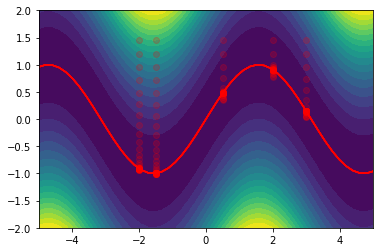

In [8]:
xspace = np.linspace(-2,2)
hyperparam = np.linspace(-5,5,50)

xmin = jax.numpy.sin(hyperparam)
lvalue = jax.vmap(jax.vmap(landscape, in_axes=(None,0)), in_axes=(0,None))(hyperparam,xspace)
grid = np.meshgrid(hyperparam,xspace,indexing = 'ij')
plt.contourf(grid[0],grid[1],lvalue, levels = 21)

for test_h in [-2.0,-1.5,0.5,2.0,3.0]:
    t2 = minimize_at_hyperparam(test_h)
    plt.scatter(np.ones_like(t2[::5])*test_h,t2[::5], alpha = 0.2, c = 'r')
    plt.plot(hyperparam,xmin,c='r')
    plt.ylim(-2,2)

Now, let's use implicit differentiation to find $\frac{\partial \hat{x}_\phi}{\partial \phi}$. Here we need to write a wrapper function `diffable_through_opt` and prepare a optimization objective (with the hyperparameter at the second argument - this is a API peculiarity and not very important)

This may look a bit complicated but at the end of the day it's just a function that returns $\hat{x}(\phi)$ given a value for the hyper parameters

In [9]:
def diffable_through_opt(hyperparam):
    def objective_fun(x, h):
        return landscape(h,x)
    solver = jaxopt.OptaxSolver(fun=objective_fun, opt=optax.adam(5e-2), implicit_diff=True)
    init_x = 1.0
    xhat = solver.run(init_x, h = hyperparam)
    xhat = xhat.params
    return xhat

We can now hax call `jax.value_and_grad` (or any jax construct, really) to get the gradients as usual

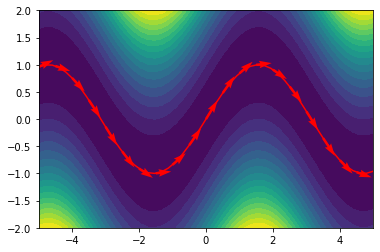

In [10]:
hyperparam_for_grad = np.linspace(-5,5,21)
xmin_for_grad = jax.numpy.sin(hyperparam_for_grad)
minimum, gradient = jax.vmap(jax.value_and_grad(diffable_through_opt))(hyperparam_for_grad)

plt.contourf(grid[0],grid[1],lvalue, levels = 21)
plt.plot(hyperparam,xmin, c = 'red')
plt.quiver(hyperparam_for_grad,xmin_for_grad,np.ones_like(gradient),gradient,units='xy',angles='xy', color = 'r')